In [52]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

%matplotlib inline

## Loading the data
We can now load the dataset into pandas using the read_csv() function. This converts the CSV file into a Pandas dataframe.

In [53]:
#Read in the csv file and convert to a Pandas dataframe
df_Football_Players = pd.read_csv("..\..\data\clean_data.csv")

In [54]:
df_Football_Players.shape

(9592, 23)

## Model




### Feature engineering: 

- Feature scaling
- Aggregation
- One hot coding

-------------------

In [55]:
df_Football_Players = df_Football_Players.drop(['name','player'],axis=1)

In [56]:
categorical_features = df_Football_Players.select_dtypes(include=object).columns
numeric_features = df_Football_Players.select_dtypes(include=np.number).columns
categorical_features

Index(['team', 'position'], dtype='object')

In [57]:
df_Football_Players = pd.get_dummies(df_Football_Players,columns=categorical_features)

In [58]:
df_Football_Players.head()

,Unnamed: 0,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,...,position_Defender Centre-Back,position_Defender Left-Back,position_Defender Right-Back,position_Goalkeeper,position_midfield,position_midfield-AttackingMidfield,position_midfield-CentralMidfield,position_midfield-DefensiveMidfield,position_midfield-LeftMidfield,position_midfield-RightMidfield
0,1,196.0,30.0,15,0.000000,0.000000,0.069018,0.0,0.0,1.242331,...,False,False,False,True,False,False,False,False,False,False
1,8,186.0,21.0,34,0.000000,0.000000,0.130529,0.0,0.0,0.000000,...,True,False,False,False,False,False,False,False,False,False
2,10,169.0,23.0,89,0.012619,0.063096,0.227145,0.0,0.0,0.000000,...,False,True,False,False,False,False,False,False,False,False
3,11,180.0,22.0,34,0.000000,0.033507,0.335071,0.0,0.0,0.000000,...,False,True,False,False,False,False,False,False,False,False
4,20,181.0,20.0,39,0.129125,0.064562,0.225968,0.0,0.0,0.000000,...,False,False,False,False,False,False,True,False,False,False


In [59]:
df_Football_Players.shape

(9592, 409)

In [60]:
# Calculate the 35th and 75th percentiles of the current_value
p35 = df_Football_Players['current_value'].quantile(0.35)
p75 = df_Football_Players['current_value'].quantile(0.75)

# Function to categorize current_value
def categorize_value(value):
    if value < p35:
        return 'low value'
    elif value < p75:
        return 'Good value'
    else:
        return 'High value'

# Apply the function to create a new column
df_Football_Players['current_value_category'] = df_Football_Players['current_value'].apply(categorize_value)

df_Football_Players.drop('current_value', axis=1, inplace=True)

# Verify the distribution of the new categories
print(df_Football_Players['current_value_category'].value_counts())

current_value_category
Good value    4029
low value     3158
High value    2405
Name: count, dtype: int64


In [61]:
encoder = LabelEncoder()
df_Football_Players['current_value_category_encoded'] = encoder.fit_transform(df_Football_Players['current_value_category'])  

#### 3. Feature selection


In [62]:
correlation = df_Football_Players.corr(numeric_only=True)
print(correlation['current_value_category_encoded'].sort_values(ascending=False))

current_value_category_encoded    1.000000
Unnamed: 0                        0.210937
position_Goalkeeper               0.143520
position_midfield                 0.105393
goals conceded                    0.093105
                                    ...   
age                              -0.128170
days_injured                     -0.144245
games_injured                    -0.153077
minutes played                   -0.233125
appearance                       -0.253403
Name: current_value_category_encoded, Length: 409, dtype: float64


In [63]:
# Set the correlation threshold
threshold = 0.12  # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['current_value_category_encoded']) > threshold]['current_value_category_encoded'].index
selected_features

Index(['Unnamed: 0', 'age', 'appearance', 'minutes played', 'days_injured',
       'games_injured', 'award', 'position_Goalkeeper',
       'current_value_category_encoded'],
      dtype='object')

In [64]:
df_Football_Players = df_Football_Players[selected_features]
df_Football_Players.head()

,Unnamed: 0,age,appearance,minutes played,days_injured,games_injured,award,position_Goalkeeper,current_value_category_encoded
0,1,30.0,15,1304,510,58,1,True,0
1,8,21.0,34,2758,47,13,0,False,0
2,10,23.0,89,7132,182,15,3,False,1
3,11,22.0,34,2686,175,28,1,False,1
4,20,20.0,39,2788,0,0,1,False,0


In [65]:
df_Football_Players.shape

(9592, 9)

### Prepare train and test data


In [66]:
# Prepare data
X = df_Football_Players.drop('current_value_category_encoded',axis=1)

# sacle the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [67]:
X.shape

(9592, 8)

### Build the model

In [68]:
wcss = []
for i in range(1, 20):  # Test 1 to 20 clusters
    kmeans = KMeans(n_clusters=i,
                    init='k-means++',
                    max_iter=300,
                    n_init=10,
                    random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)  # inertia_ is the WCSS

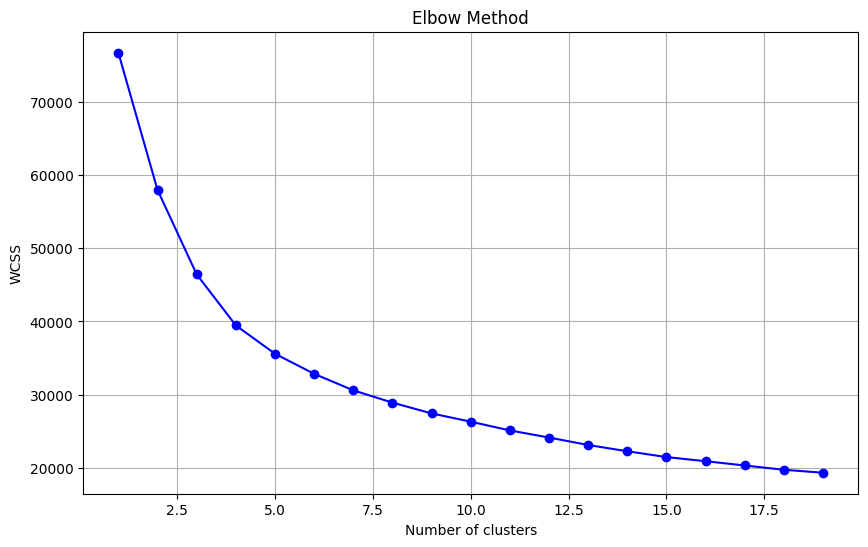

In [69]:
# 3. Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 20), wcss,  marker='o', linestyle='-', color='b')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [70]:
# Optional: Apply k-Means using the optimal number of clusters
optimal_clusters = 8 # This might change based on your actual elbow curve analysis
model = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)

### Train and Test the Model

In [71]:
# Fit the model on the training data
y_pred = model.fit_predict(X_scaled)

### Evaluating the Model

In [72]:
X.head(2)


,Unnamed: 0,age,appearance,minutes played,days_injured,games_injured,award,position_Goalkeeper
0,1,30.0,15,1304,510,58,1,True
1,8,21.0,34,2758,47,13,0,False


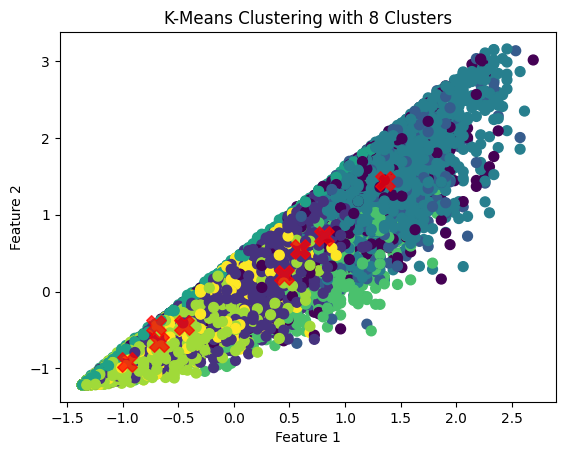

In [73]:
# Plotting the clusters with optimal number
plt.scatter(X_scaled[:, 2], X_scaled[:, 3], c=y_pred, s=50, cmap='viridis')

centers = model.cluster_centers_
plt.scatter(centers[:, 2], centers[:, 3], c='red', s=200, alpha=0.75, marker='X')
plt.title(f'K-Means Clustering with {optimal_clusters} Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [74]:
X['kmeans'] = y_pred

In [75]:
X['kmeans'].value_counts()

kmeans
6    2110
5    1569
3    1500
1    1381
4     945
2     851
7     694
0     542
Name: count, dtype: int64

In [76]:
X[X['kmeans']==1]

,Unnamed: 0,age,appearance,minutes played,days_injured,games_injured,award,position_Goalkeeper,kmeans
846,1256,31.0,12,609,32,4,2,False,1
872,1282,32.0,25,1844,58,8,1,False,1
965,1381,33.0,19,1255,0,0,2,False,1
1058,1480,34.0,44,1295,61,9,1,False,1
1183,1696,32.0,23,1201,13,1,1,False,1
...,...,...,...,...,...,...,...,...,...
9577,10738,27.0,23,1555,63,6,0,False,1
9579,10740,33.0,44,3585,41,5,1,False,1
9580,10741,34.0,33,2375,93,10,1,False,1
9584,10746,30.0,12,813,69,11,0,False,1


<Axes: xlabel='minutes played', ylabel='appearance'>

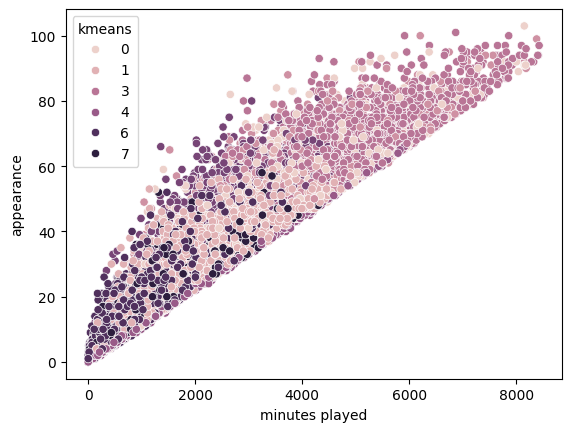

In [77]:
sns.scatterplot(data = X , x = 'minutes played', y = 'appearance', hue = 'kmeans')


<Axes: xlabel='days_injured', ylabel='games_injured'>

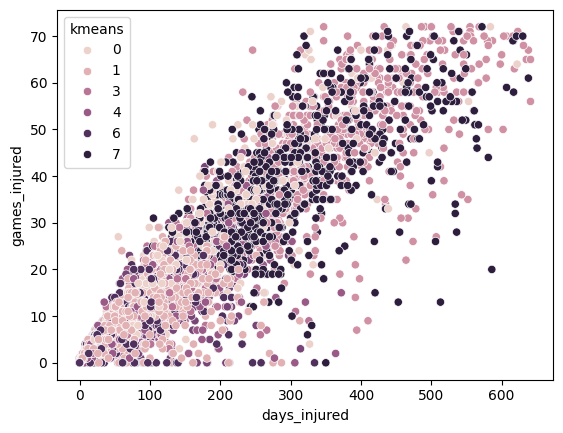

In [79]:
sns.scatterplot(data = X , x = 'days_injured', y = 'games_injured', hue = 'kmeans')
